This notebook will be used to clean the parser log dataset

In [ ]:
#loading the gdrive
from google.colab import drive 
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
#loading the packages
!pip install pydot --quiet
!pip install gensim==3.8.3 --quiet
!pip install tensorflow-datasets --quiet
!pip install -U tensorflow-text==2.8.2 --quiet
!pip install transformers --quiet

In [ ]:
#loading the packages
import pandas as pd
import numpy as np
import sys
import os
import re

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.layers import Embedding, Input, Dense, Lambda
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
import tensorflow_text as tf_text

from transformers import BertTokenizer, TFBertModel


import sklearn as sk

import nltk
from nltk.data import find

import matplotlib.pyplot as plt

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where

#This continues to work with gensim 3.8.3.  It doesn't yet work with 4.x.  
#Make sure your pip install command specifies gensim==3.8.3
import gensim

In [ ]:
os.chdir('/content/gdrive/MyDrive/bgl/')

In [ ]:
#downloading the BGL structured dataset
df=pd.read_csv('bgl2_structured.csv')

Cleaning the content, which has the log information in english language, we will clean the content off all the special characters, period etc.

In [ ]:
#copying the content file for cleaning purpose
df['Content1']=df['Content']

creating the label using the label column, the label is labelled as '-', we convert it into 0 for no events and 1 for severe events.

In [ ]:
df['Label1'] = df['Label'].map(lambda x: 0 if (x == '-') else 1) 
df.head()

,LineId,Label,Id,Date,Code1,Time,Code2,Component1,Component2,Level,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0


Cleaining all the log content data of all the special characters

In [ ]:
df['Content1'].replace( { r'(0x)[0-9a-fA-F]+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'\d+\.\d+\.\d+\.\d+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'(?<=Warning: we failed to resolve data source name )[\w\s]+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'\d+' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r':' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'|' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'=' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'/' : ' ' }, inplace= True, regex = True)
df['Content1'].replace( { r'()' : '' }, inplace= True, regex = True)
df['Content1'].replace( { r'_' : ' ' }, inplace= True, regex = True)
df['Content1'].replace( { r',' : '' }, inplace= True, regex = True)


In [ ]:
g = df.groupby('Label1')['EventId'].unique()

Looking at the balance of the label parameter

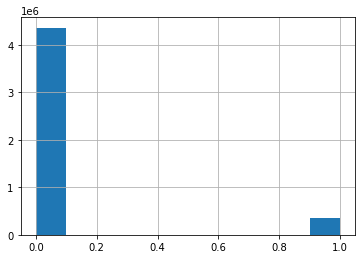

In [ ]:
df["Label1"].hist()

In [ ]:
df['Label1'].value_counts()

0    4364795
1     348698
Name: Label1, dtype: int64

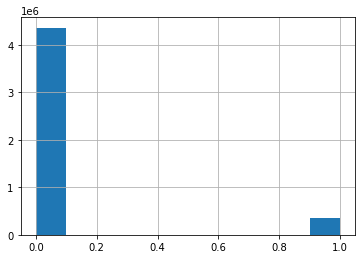

In [ ]:
df['Label1'].hist()

In [ ]:
df.head()

,LineId,Label,Id,Date,Code1,Time,Code2,Component1,Component2,Level,Content,EventId,EventTemplate,Content1,Label1
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0


Creating a field which is combination of the component 1, component2 and level infront of the content to create more context for the content field and also help with the BERT model later on

In [ ]:
df['combined'] = df['Component1'].astype(str)+' '+df['Component2'].astype(str)+' '+df['Level'].astype(str)+' '+df['Content1'].astype(str)+' '+df['EventId'].astype(str)

In [ ]:
df.head()

,LineId,Label,Id,Date,Code1,Time,Code2,Component1,Component2,Level,Content,EventId,EventTemplate,Content1,Label1,combined
0,1,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.363779,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0,RAS KERNEL INFO instruction cache parity error...
1,2,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.527847,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0,RAS KERNEL INFO instruction cache parity error...
2,3,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.675872,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0,RAS KERNEL INFO instruction cache parity error...
3,4,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.823719,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0,RAS KERNEL INFO instruction cache parity error...
4,5,-,1117838570,2005.06.03,R02-M1-N0-C:J12-U11,2005-06-03-15.42.50.982731,R02-M1-N0-C:J12-U11,RAS,KERNEL,INFO,instruction cache parity error corrected,3aa50e45,instruction cache parity error corrected,instruction cache parity error corrected,0,RAS KERNEL INFO instruction cache parity error...


Creating a smaller dataframe from the big database to be used for modelling

In [ ]:
df2 = df[['Component1', 'Component2','Level','Content1','EventId','Label1','combined']].copy()

Saving the dataset into a csv file

In [ ]:
df2.to_csv('clean_log_bgl.csv', encoding='utf-8')

In [ ]:

whole_data_emb= df2["Content1"]
whole_data_label=df2["Label1"]